✅ Loaded model.
✅ Encoded z_A and z_B.


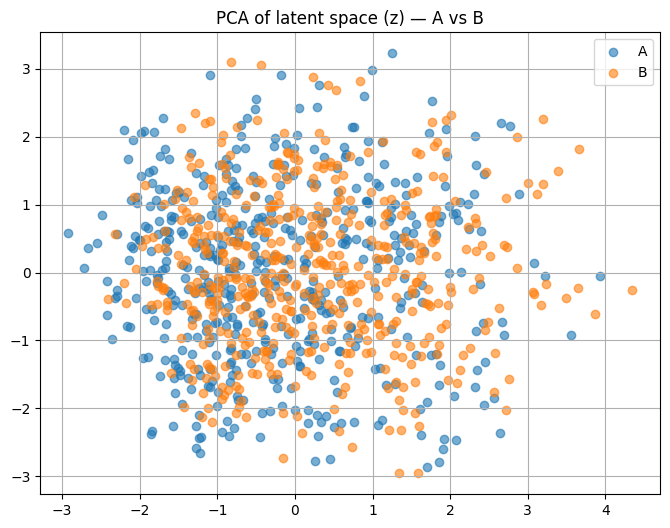

/Users/gijsbartholomeus/Documents/STUDIE/MSc/VSCODEFILE/.venv/lib/python3.8/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


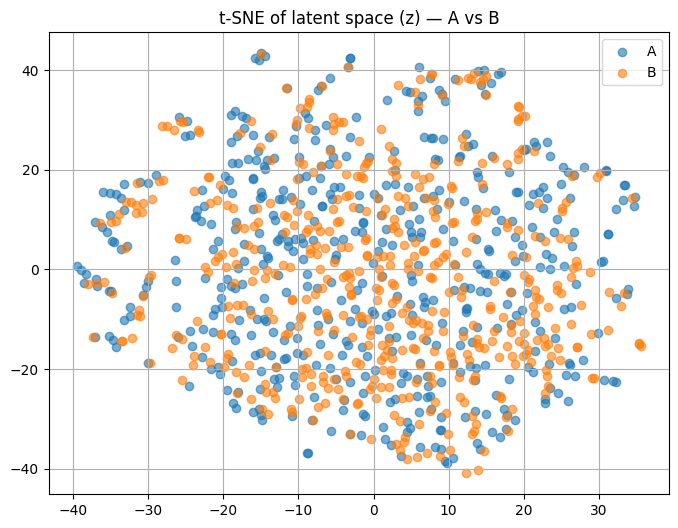

In [1]:
# %% [markdown]
# # 🎨 Visualize Latent Space of VAE (A vs B)
# 
# We load the trained CVAE and visualize the latent representations of Algo A and Algo B images.

# %%
# ✅ Imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# %%
# ✅ Define same CVAE class as used in training

class CVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc_mu = nn.Linear(64 * 12 * 12, latent_dim)
        self.fc_logvar = nn.Linear(64 * 12 * 12, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim + 1, 64 * 12 * 12)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def encode(self, x, label):
        label = label.view(-1, 1, 1, 1).expand(-1, 1, x.size(2), x.size(3))
        x_cond = torch.cat([x, label], dim=1)
        h = self.encoder(x_cond).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

# %%
# ✅ Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 16

model = CVAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("cvae_harmonization.pth", map_location=device))
model.eval()

print("✅ Loaded model.")

# %%
# ✅ Load datasets
A = np.load("../../data/augmented_images_algoA.npy")
B = np.load("../../data/augmented_images_algoB.npy")

# Select N samples per domain (to keep t-SNE faster)
N_samples = 500
A_subset = A[np.random.choice(len(A), N_samples, replace=False)]
B_subset = B[np.random.choice(len(B), N_samples, replace=False)]

# Convert to torch
X_A = torch.tensor(A_subset[:, None, :, :], dtype=torch.float32).to(device)
X_B = torch.tensor(B_subset[:, None, :, :], dtype=torch.float32).to(device)
labels_A = torch.zeros(len(X_A), device=device)
labels_B = torch.ones(len(X_B), device=device)

# %%
# ✅ Encode A → z_A
with torch.no_grad():
    mu_A, _ = model.encode(X_A, labels_A)
    z_A = mu_A.cpu().numpy()

# Encode B → z_B
with torch.no_grad():
    mu_B, _ = model.encode(X_B, labels_B)
    z_B = mu_B.cpu().numpy()

print("✅ Encoded z_A and z_B.")

# %%
# ✅ Combine latent vectors and labels for visualization
z_all = np.concatenate([z_A, z_B], axis=0)
labels_all = np.concatenate([np.zeros(len(z_A)), np.ones(len(z_B))])

# %%
# ✅ PCA visualization
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_all)

plt.figure(figsize=(8,6))
plt.scatter(z_pca[labels_all==0,0], z_pca[labels_all==0,1], label='A', alpha=0.6)
plt.scatter(z_pca[labels_all==1,0], z_pca[labels_all==1,1], label='B', alpha=0.6)
plt.legend()
plt.title("PCA of latent space (z) — A vs B")
plt.grid(True)
plt.show()

# %%
# ✅ t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
z_tsne = tsne.fit_transform(z_all)

plt.figure(figsize=(8,6))
plt.scatter(z_tsne[labels_all==0,0], z_tsne[labels_all==0,1], label='A', alpha=0.6)
plt.scatter(z_tsne[labels_all==1,0], z_tsne[labels_all==1,1], label='B', alpha=0.6)
plt.legend()
plt.title("t-SNE of latent space (z) — A vs B")
plt.grid(True)
plt.show()
